In [1]:
# import numpy as np
# import torch
# import torch.optim as optim
# import os
# import glob
# from PIL import Image
# import matplotlib.pyplot as plt
# import torchvision.transforms as T
# from torch.utils.data import Dataset, DataLoader
# import numpy as np
# %matplotlib inline

In [24]:
import os
import cv2
import time
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.models import resnet50

from sklearn.model_selection import train_test_split

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
dataset_path = "D:\pytorch_catsanddogs\dataset"

TRAIN_SET = dataset_path+"\\train"
TEST_SET = dataset_path+"\\test"

In [26]:
train_imgs = []
val_imgs = []
for roots,dirs,files in os.walk(TRAIN_SET):
    train_imgs.extend(files)
for root,dirs,files in os.walk(TEST_SET):
    val_imgs.extend(files)

In [27]:
def class_to_int(label):
    if label == 'cat':
        return 0
    if label == 'dog':
        return 1

In [28]:
def get_train_transform():
    return T.Compose([
        T.ToTensor(),
        T.Normalize((0, 0, 0),(1 , 1, 1))
    ])
def get_val_transform():
    return T.Compose([
        T.ToTensor(),
        T.Normalize((0, 0, 0),(1 , 1, 1))
    ])

In [29]:
class CreateDataset(Dataset):
    def __init__(self, imgs, mode = 'train', transforms=None):
        super().__init__()
        self.imgs = imgs
        self.mode = mode
        self.transforms = transforms
    
    def __getitem__(self, idx):
        image_name = self.imgs[idx]
        image_name_list = image_name.split('.')
        if self.mode == 'train':
            if image_name_list[0] == 'cat':
                img = Image.open(TRAIN_SET+'\\cats\\'+image_name)
            elif image_name_list[0] == 'dog':
                img = Image.open(TRAIN_SET+'\\dogs\\'+image_name)
        if self.mode == 'val':
            if image_name_list[0] == 'cat':
                img = Image.open(TEST_SET+'\\cats\\'+image_name)
            elif image_name_list[0] == 'dog':
                img = Image.open(TEST_SET+'\\dogs\\'+image_name)
            
        img = img.resize((224, 224))
        if self.mode == 'train' or self.mode == 'val':
            label = class_to_int(image_name_list[0])
            label = torch.tensor(label, dtype = torch.float32)
            
            img = self.transforms(img)
            
            return img, label
        
        elif self.mode == 'test':
            img = self.transforms(img)
            return img
        
    def __len__(self):
        return(len(self.imgs))    

In [30]:
train_dataset = CreateDataset(train_imgs, mode = 'train', transforms = get_train_transform())
val_dataset = CreateDataset(val_imgs, mode = 'val', transforms = get_val_transform())

In [31]:
train_data_loader = DataLoader(
            dataset = train_dataset,
            num_workers = 0,
            batch_size = 16,
            shuffle = True
)
val_data_loader = DataLoader(
            dataset = val_dataset,
            num_workers = 0,
            batch_size = 16,
            shuffle = True
)

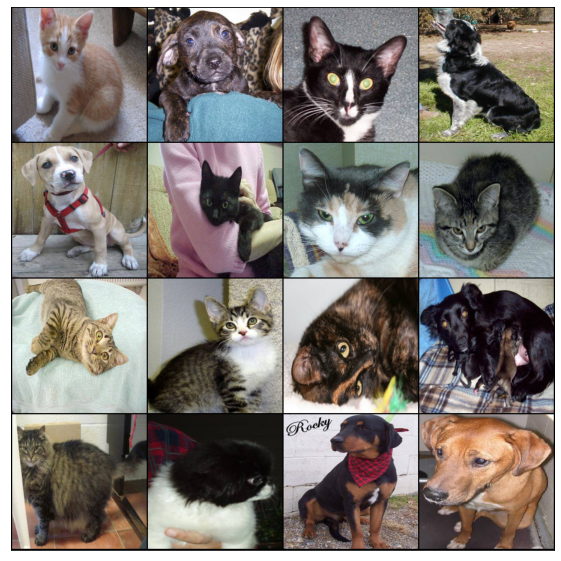

In [32]:
for images, labels in train_data_loader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break

In [33]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [34]:
def accuracy(preds, trues):
    
    ### Converting preds to 0 or 1
    preds = [1 if preds[i] >= 0.5 else 0 for i in range(len(preds))]
    
    ### Calculating accuracy by comparing predictions with true labels
    acc = [1 if preds[i] == trues[i] else 0 for i in range(len(preds))]
    
    ### Summing over all correct predictions
    acc = np.sum(acc) / len(preds)
    
    return (acc * 100)

In [35]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    for images, labels in train_data_loader:
        print(labels)
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1))
        
        optimizer.zero_grad()
        
        preds = model(images)
        
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)
        
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)
    end_time = time.time()
    total_time = end_time - start_time
    
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    
    train_logs['loss'].append(epoch_loss)
    train_logs['accuracy'].append(epoch_acc)
    train_logs['time'].append(total_time)
    
    return epoch_loss, epoch_acc, total_time

In [36]:
def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    for images, labels in val_data_loader:
        
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1))
        
        optimizer.zero_grad()
        
        preds = model(images)
        
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)
        
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)
    end_time = time.time()
    total_time = end_time - start_time
    
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    
    train_logs['loss'].append(epoch_loss)
    train_logs['accuracy'].append(epoch_acc)
    train_logs['time'].append(total_time)
    
    return epoch_loss, epoch_acc, total_time, best_val_acc

In [37]:
model = resnet50(pretrained = True)

model.fc = nn.Sequential(
                nn.Linear(2048, 1, bias = True),
                nn.Sigmoid()
)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [38]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)

criterion = nn.BCELoss()

train_logs = {'loss' : [], 'accuracy' : [], 'time' : []}
val_logs = {'loss' : [], 'accuracy' : [], 'time' : []}

model.to(device)

epochs = 10

In [39]:
best_val_acc = 0
for epoch in range(epochs):
    loss, acc, _time = train_one_epoch(train_data_loader)
    
    print("Training")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))
    
    loss, acc, _time, best_val_acc = val_one_epoch(val_data_loader, best_val_acc)
    
    print("Validating")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))

tensor([1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1.])
tensor([1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1.])
tensor([1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.])
tensor([1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0.])
tensor([1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1.])
tensor([0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.])
tensor([0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0.])
tensor([0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.])
tensor([1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1.])
tensor([0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.])
tensor([1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1.])
tensor([0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1.])
tensor([1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.])
tensor([1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,

tensor([0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0.])
tensor([1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0.])
tensor([1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1.])
tensor([0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0.])
tensor([1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1.])
tensor([0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1.])
tensor([0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1.])
tensor([1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0.])
tensor([0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1.])
tensor([1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0.])
tensor([1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0.])
tensor([1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.])
tensor([0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,

tensor([0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0.])
tensor([0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.])
tensor([0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0.])
tensor([1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1.])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1.])
tensor([1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.])
tensor([0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0.])
tensor([0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1.])
tensor([1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1.])
tensor([0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.])
tensor([1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1.])
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1.])
tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0.,

tensor([0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1.])
tensor([0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1.])
tensor([0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1.])
tensor([0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0.])
tensor([0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1.])
tensor([1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0.])
tensor([1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0.])
tensor([0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1.])
tensor([1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1.])
tensor([0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1.])
tensor([0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.])
tensor([0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0.])
tensor([0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
tensor([0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0.,

tensor([0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1.])
tensor([1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1.])
tensor([1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1.])
tensor([0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1.])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1.])
tensor([1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.])
tensor([0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0.])
tensor([1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.])
tensor([0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0.])
tensor([0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1.])
tensor([1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1.])
tensor([0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.,

tensor([0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.])
tensor([0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1.])
tensor([0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0.])
tensor([0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0.])
tensor([0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.])
tensor([1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1.])
tensor([1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0.])
tensor([1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1.])
tensor([1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0.])
tensor([1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0.])
tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0.])
tensor([1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1.])
tensor([0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,

tensor([0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0.])
tensor([0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1.])
tensor([0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0.])
tensor([1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0.])
tensor([1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0.])
tensor([0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1.])
tensor([0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0.])
tensor([0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.])
tensor([0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.])
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.])
tensor([0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0.])
tensor([0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1.,

tensor([0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0.])
tensor([1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1.])
tensor([1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0.])
tensor([0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.])
tensor([0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.])
tensor([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1.])
tensor([1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1.])
tensor([0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0.])
tensor([1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0.])
tensor([0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0.])
tensor([1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0.])
tensor([1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1.])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,

tensor([0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0.])
tensor([1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1.])
tensor([0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1.])
tensor([0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1.])
tensor([1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0.])
tensor([1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0.])
tensor([1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0.])
tensor([0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.])
tensor([1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0.])
tensor([0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1.])
tensor([0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0.])
tensor([1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1.,

tensor([1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1.])
tensor([0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.])
tensor([0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0.])
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1.])
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.])
tensor([0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1.])
tensor([1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1.])
tensor([1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1.])
tensor([0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0.])
tensor([0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0.])
tensor([1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0.,

tensor([1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.])
tensor([0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1.])
tensor([1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1.])
tensor([0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1.])
tensor([0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1.])
tensor([0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1.])
tensor([1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0.])
tensor([1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0.])
tensor([1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0.])
tensor([0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.])
tensor([1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0.])
tensor([1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.])
tensor([0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1.,

ValueError: not enough values to unpack (expected 4, got 3)